<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/MAFVariationalMutualInformationPzFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `TheLastMetric`: An Information Metric for Observing Strategy Optimization for Photo-z

In [13]:
!pip install --quiet pzflow corner
!git clone https://github.com/aimalz/TheLastMetric.git
%cd TheLastMetric

Cloning into 'TheLastMetric'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 26), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), done.
/content/TheLastMetric


## Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [2]:
!wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
!tar -xzf for_malz_and_lanusse.tar.gz
!mv for_malz_and_lanusse dataset

--2021-04-02 19:33:11--  https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35901537 (34M) [application/gzip]
Saving to: ‘for_malz_and_lanusse.tar.gz’

for_malz_and_lanuss 100%[===================>]  34.24M  86.5MB/s    in 0.4s    

2021-04-02 19:33:12 (86.5 MB/s) - ‘for_malz_and_lanusse.tar.gz’ saved [35901537/35901537]



In [3]:
more dataset/readme.txt

In [4]:
all_readme = open('dataset/readme.txt').read().split('\n')
metadata = []
for i, line in enumerate(all_readme[1:13]):
  descr = all_readme[i+16].split()[2:]
  metadata.append(line.split() + [descr])
print(metadata)

[['1_4_y10', 'baseline_v1_5_10yrs', '25.86', '27.02', '26.99', '26.42', '25.70', '24.94', ['y,', 'y', 'uncertainty']], ['4_38_y10', 'footprint_stuck_rollingv1_5_10yrs', '25.56', '26.68', '26.62', '26.06', '25.33', '24.61', ['u-g,', 'u-g', 'uncertainty']], ['10_92_y10', 'ddf_heavy_nexp2_v1_6_10yrs', '25.57', '26.82', '26.84', '26.26', '25.57', '24.82', ['g-r,', 'g-r', 'uncertainty']], ['4_34_y10', 'footprint_newAv1_5_10yrs', '25.75', '26.87', '26.85', '26.29', '25.55', '24.78', ['r-i,', 'r-i', 'uncertainty']], ['7_61_y10', 'third_obs_pt60v1_5_10yrs', '25.87', '27.03', '26.99', '26.43', '25.70', '24.93', ['i-z,', 'i-z', 'uncertainty']], ['9_86_y10', 'barebones_v1_6_10yrs', '26.00', '27.13', '27.07', '26.57', '25.78', '25.05', ['z-y,', 'z-y', 'uncertainty']], [[]], ['test.cat', 'contains', 'the', 'simulated', 'observed', 'apparent', 'magnitudes', ['the', 'photo-z', 'results']], ['0', ':', 'identifier', ['identifier']], ['1', ':', 'true', 'redshift', ['true', 'redshift']], ['2,3', ':', 'u,

In [5]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')

In [6]:
available_os = ['run_1_4_y10', 'run_4_38_y10']
os_colors = {'run_1_4_y10': 'k', 'run_4_38_y10': '#2ca02c'}

In [7]:
from astropy.table import Table

phot_cats, z_cats = {}, {}
for one_os in available_os:
  test_cat = Table.read('dataset/'+one_os+'/test.cat', format='ascii')


  z_cat = Table.read('dataset/'+one_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read('dataset/'+one_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[one_os] = phot_cat
  z_cats[one_os] = z_cat

Populating the interactive namespace from numpy and matplotlib


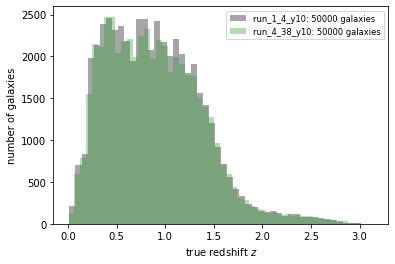

In [8]:
%pylab inline
for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=50, alpha=0.35, color=os_colors[which_os], 
       label=which_os+': '+str(len(phot_cats[which_os]))+' galaxies')
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')
# title(str(len(phot_cats['baseline_v1.4_10yrs']))+' galaxies')

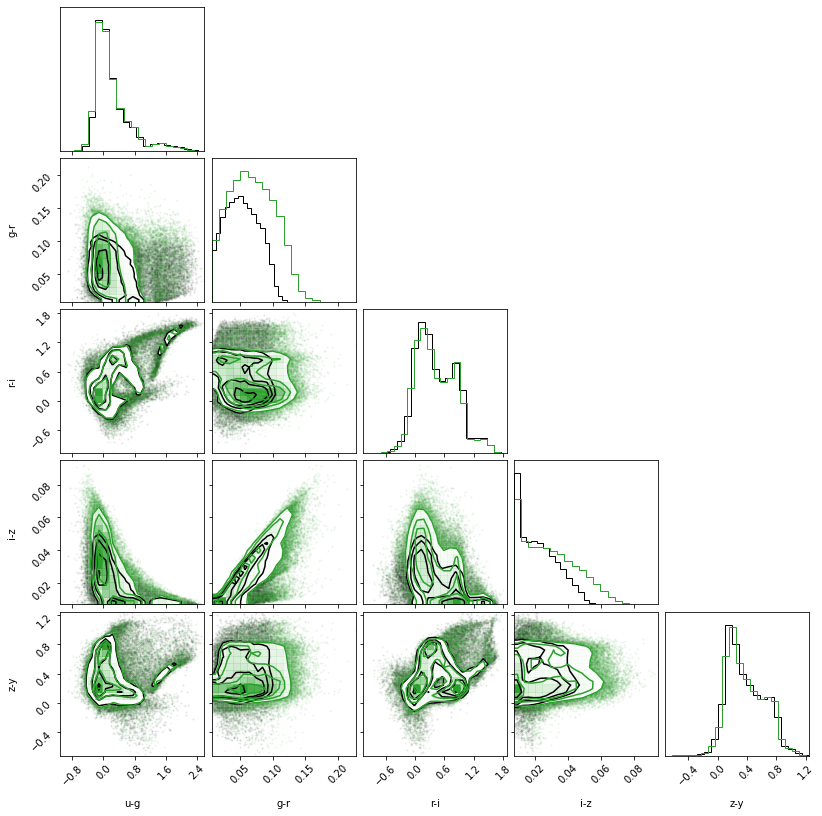

In [22]:
import corner

labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os]['u-g'], phot_cats[one_os]['g-r'], phot_cats[one_os]['r-i'], phot_cats[one_os]['i-z'], phot_cats[one_os]['z-y']]).T
fig = corner.corner(prep_for_corner('run_1_4_y10'), labels=labels)
for which_os in available_os[1:]:
  corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os])
# corner.corner(prep_for_corner('var_expt_v1.4_10yrs'), fig=fig, color='r')
# corner.corner(prep_for_corner('weather_1.2_v1.4_10yrs'), fig=fig, color='b')

# note to self: try some of these tricks https://github.com/tommasotreu/AARV/blob/master/attic/spare-or-old-figures/DdtDa.ipynb
# also choose friendlier colors!

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

In [14]:
# Here we just need to load the PZFlow code
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import corner
from pzflow import Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling

In [15]:
flows = {}
for os in available_os:
  flows[os] = Flow(file=f"trained_flows/flow_for_{os}.pkl")

In [33]:
# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

In [38]:
tx = np.linspace(0,3.5,100)
all_logp = {}
for which_os in available_os:
  flow = flows[which_os]
  cat = catalogs[which_os]
  logp = flow.posterior(flow.info["condition_scaler"](cat), column="z_true", grid=tx)
  all_logp[which_os] = logp

In [ ]:
# tx = np.linspace(0,3.5,100)
# logp = dist.log_prob(tx)

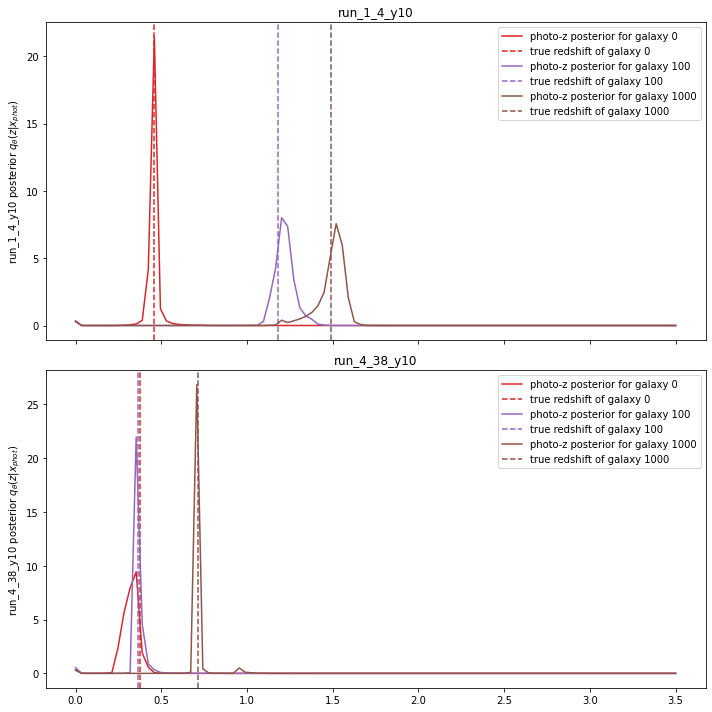

In [46]:
fig, ax = subplots(2, 1, figsize=(10, 10), sharex=True)
for i, which_os in enumerate(available_os):
  ax[i].set_ylabel(which_os+r' posterior $q_{\theta}(z | x_{phot})$')
  ax[i].set_title(which_os)
  logp = all_logp[which_os]
  batch = catalogs[which_os]
  ax[i].plot(tx, (logp[0]), color='#d62728', label='photo-z posterior for galaxy 0')
  ax[i].axvline(batch['z_true'][0], linestyle='--', color='#d62728', label='true redshift of galaxy 0')
  ax[i].plot(tx, (logp[100]), color='#9467bd',  label='photo-z posterior for galaxy 100')
  ax[i].axvline(batch['z_true'][100], linestyle='--', color='#9467bd', label='true redshift of galaxy 100')
  ax[i].plot(tx, (logp[1000]), color='#8c564b', label='photo-z posterior for galaxy 1000')
  ax[i].axvline(batch['z_true'][1000], linestyle='--', color='#8c564b', label='true redshift of galaxy 1000')
  ax[i].legend(loc='upper right')
  if i == 3:
    ax[i].set_xlabel(r'redshift $z$')
fig.tight_layout()
fig.show()

This plot should show the redshift posterior distribution for given photometry $q_\theta(z | x_{phot})$. 

We are going to use that to compute our lower bound on the mutual information

$$I(z; x_{phot})  \geq \mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between observing strategies. Only the first term depends on the observed photometry, so it is the only one we have to compare between `OpSim` runs.

In [ ]:
all_milb = {}
for which_os in available_os:
  phot_cat = phot_cats[which_os]

  x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
  y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

  mutual_information_lower_bound = model(x).log_prob(y)
  all_milb[which_os] = mutual_information_lower_bound

In [ ]:
# surprisingly not so different from one another, but I think we do anticipate "weather" to have more weight at low values of the lower bound
for which_os in available_os:
  mutual_information_lower_bound = all_milb[which_os]
  hist(-1.*np.log(-1.*mutual_information_lower_bound.flatten()), bins=50, alpha=0.3, color=os_colors[which_os], label=which_os)
  xlabel(r'$-log[-\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]]$')
xlim(-10., 5.)
legend(loc='upper left')
# semilogy()

In [ ]:
# #not very informative

# fig, ax = subplots(4, 5, figsize=(25, 20), sharey=True)
# for j, which_os in enumerate(available_os):
#   phot_cat = phot_cats[which_os]
#   mutual_information_lower_bound = all_milb[which_os]
#   for i, col in enumerate(['u-g', 'g-r', 'r-i', 'i-z', 'z-y']):
#     ax[j][i].set_xlabel(col)
#     img = ax[j][i].scatter(phot_cat[col], mutual_information_lower_bound.flatten(), c=phot_cat['z_true'], cmap=mpl.cm.viridis_r, s=0.1)
#     if i == 0:
#       ax[j][i].set_ylabel(which_os+r' $\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#     if i == 4:
#       fig.colorbar(img, ax=ax[j][i], label=r'redshift $z$')
#       ax[j][i].set_ylim(-5., 1.)
# fig.tight_layout()
# fig.show()

In [ ]:
# Contour/KDE won't work because of crazy outliers. . .

# from scipy import stats as sps
# def density_estimation(m1, m2):
#     x = np.linspace(0., 2.5, 64)
#     y = np.linspace(-5., 1., 64)
#     X, Y = np.meshgrid(x, y)
#     # X, Y = npo.mgrid[0.:2.5:64j, -5.:1.:64j]                                                     
#     positions = npo.vstack([X.ravel(), Y.ravel()])                                                       
#     values = npo.vstack([m1, m2])                                                                        
#     kernel = sps.gaussian_kde(values)                                                                 
#     Z = np.reshape(kernel(positions).T, X.shape)
#     return X, Y, Z
# (x, y, z) = density_estimation(phot_cat['z_true'], mutual_information_lower_bound.flatten())
# contour(x, y, z)


In [ ]:
# for which_os in available_os:
#   phot_cat = phot_cats[which_os]
#   mutual_information_lower_bound = all_milb[which_os]
#   hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
#         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
#   colorbar()
#   xlabel(r'redshift $z$')
#   ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   title(which_os)
#   show()

# # hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
# #         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
# # colorbar()

# # # scatter(phot_cat['z_true'], mutual_information_lower_bound.flatten(), s=0.1)
# # # xlim(0., 2.5)
# # # ylim(-5., 1.)

# # xlabel(r'redshift $z$')
# # ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# # title('TheLastMetric on '+just_one_os)

In [ ]:
# for which_os in available_os:
#   phot_cat = phot_cats[which_os]
#   # for zran in 
#   mutual_information_lower_bound = all_milb[which_os]
#   hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
#         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
#   colorbar()
#   xlabel(r'redshift $z$')
#   ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   title(which_os)
# show()

# # hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
# #         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
# # colorbar()

# # # scatter(phot_cat['z_true'], mutual_information_lower_bound.flatten(), s=0.1)
# # # xlim(0., 2.5)
# # # ylim(-5., 1.)

# # xlabel(r'redshift $z$')
# # ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# # title('TheLastMetric on '+just_one_os)

In [ ]:
onp.histogram2d

In [ ]:
# TODO: get rid of diagonal
fig, ax = subplots(4, 4, figsize=(20, 20), sharey=True, sharex=True)
hists = {}
for j, base_os in enumerate(available_os):
  phot_cat = phot_cats[base_os]
  mutual_information_lower_bound = all_milb[base_os]
  x = onp.linspace(0., 2.5, 64)
  y = onp.linspace(-5., 1., 64)
  h, x, y = onp.histogram2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), bins=(x, y), density=True)#64)#, extent=np.array([[0.,2.5], [-5.,1.]]))
  hists[base_os] = h
extrema = [0., 0.]
for j, base_os in enumerate(available_os):
  for i, comp_os in enumerate(available_os):
    diff_hist = hists[base_os] - hists[comp_os]
    comp_extrema = [onp.min(diff_hist), onp.max(diff_hist)]
    extrema = [min(comp_extrema[0], extrema[0]), max(comp_extrema[1], extrema[1])]
    img = ax[j][i].imshow(diff_hist.T, origin='lower', cmap=mpl.cm.viridis_r, vmin=-0.4, vmax=0.4, extent=[0.,2.5,-5.,1.], aspect='auto')
    ax[j][i].text(0., 1.1, base_os+' - '+comp_os)
    ax[j][i].set_ylabel(r'$\Delta\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
    fig.colorbar(img, ax=ax[j][i])
    ax[j][i].set_xlabel(r'redshift $z$')
fig.tight_layout()
fig.show()
print(extrema)

In [ ]:
# next step: make corner plot of differences between distributions as 2D histograms, since contour/KDE fails

In [ ]:
# mutual_information_lower_bound

## Computing the bound for various opsim runs

In [ ]:
test_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)
phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())

In [ ]:
batch_size = 512
def get_batch():
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds],phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [ ]:
_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

In [ ]:
for epoch in range(10000):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  if epoch % 1000 == 0:
    print(epoch, l)
  losses.append(l)

In [ ]:
plot(np.array(losses[2000:]))

In [ ]:
batch = get_batch()
dist = optimizer.target(batch['x'])

In [ ]:
tx = np.linspace(0,3.5,100)
logp = dist.log_prob(tx)

In [ ]:
plot(tx, np.exp(logp[0]))
axvline(batch['y'][0], color='C0')
plot(tx, np.exp(logp[1]))
axvline(batch['y'][1], color='C1')

In [ ]:
x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

mutual_information_lower_bound = model(x).log_prob(y)

In [ ]:
np.mean(mutual_information_lower_bound)

In [ ]:
hist2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64,
       range=[[0,2.5], [-5,1]]);
xlabel('Redshift')
ylabel(r'$\mathbb{E}_{z, phot} \left[ q_\theta(z | phot ) \right]$')
title('weather_1.2_v1.4_10yrs')

In [ ]:
mutual_information_lower_bound.shape